Определение мошенничества с кредитными картами
Набор данных: Credit Card Fraud Detection dataset на Kaggle.
https://habr.com/ru/companies/nix/articles/425907/ обучение чего то по разным моделям
https://habr.com/ru/articles/491552/ про автоэнкодеры
https://habr.com/ru/companies/nix/articles/478286/ про автоэнкодеры и несколько стандартных моделей на этом датасете 

In [2]:
import pandas as pd

creditcard_data = pd.read_csv("datasets/creditcard.csv")

creditcard_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Маштабируем (столбцы Time и Amount)

In [4]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
creditcard_data["Amount"] = robust_scaler.fit_transform(creditcard_data["Amount"].values.reshape(-1, 1)) 
creditcard_data["Time"] = robust_scaler.fit_transform(creditcard_data["Time"].values.reshape(-1, 1))

x = creditcard_data.drop(columns='Class') 
y = creditcard_data['Class']

Разделяем на обучающую и тестовую выборки

Oversampling. Библиотекой увеличиваю количество случаев кардерства в датасете. Это ухудшало результаты и было удалено.

Обучим модели: логистическую регрессию, SVM, случайный лес, градиентный бустинг

Best parameters found:  {'C': 1, 'max_iter': 50}
              precision    recall  f1-score   support

     Обычная       1.00      1.00      1.00     85296
      Кардер       0.84      0.66      0.74       147

    accuracy                           1.00     85443
   macro avg       0.92      0.83      0.87     85443
weighted avg       1.00      1.00      1.00     85443



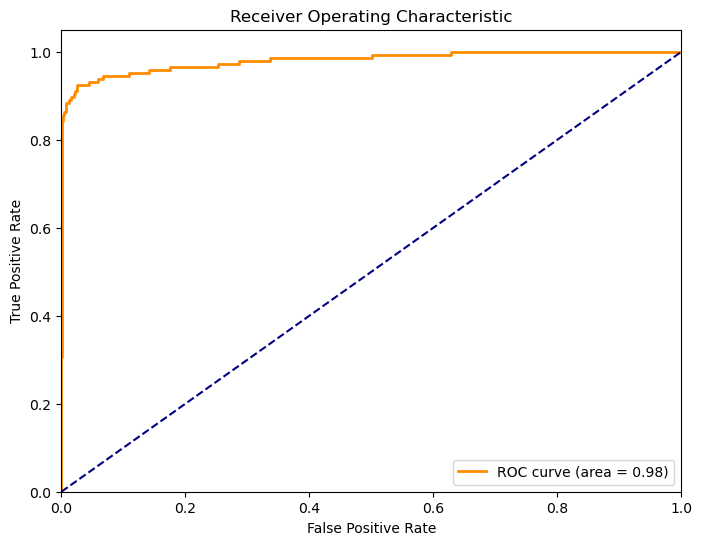

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [10, 20, 50, 70, 100],
}

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3 ,random_state=50)

grid_search1 = GridSearchCV(LogisticRegression(penalty='l2', random_state=50), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=3)
grid_search1.fit(x_train, y_train)

best_model1 = grid_search1.best_estimator_
y_pred = best_model1.predict(x_test)
print("Best parameters found: ", grid_search1.best_params_)

print(classification_report(y_test, y_pred, target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test,  best_model1.predict_proba(x_test)[:, 1])
auc = roc_auc_score(y_test, best_model1.predict_proba(x_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Высокая общая точность (accuracy): Accuracy 0.98 может ввести в заблуждение. Несмотря на кажущуюся высокую точность, модель плохо справляется с определением мошеннических транзакций (класс 1). Это происходит из-за сильного дисбаланса классов: обычных транзакций (класс 0) гораздо больше, чем мошеннических (класс 1).

Отличные результаты для обычных транзакций (класс 0): Precision и recall для класса 0 очень высокие, что говорит о том, что модель хорошо определяет обычные транзакции. Это ожидаемо, учитывая их преобладающее количество в наборе данных.

Проблемы с мошенническими транзакциями (класс 1):

Очень низкая precision: Precision для класса 1 составляет всего 0.06. Это означает, что из всех транзакций, которые модель пометила как мошеннические, только 6% действительно являются мошенническими. Модель генерирует много ложных срабатываний.

Высокий recall: Recall для класса 1 составляет 0.90. Это означает, что модель обнаруживает 90% всех мошеннических транзакций. Хотя это и хорошо, низкая точность делает модель практически бесполезной, так как приводит к большому количеству ложных срабатываний.

Низкий F1-score для класса 1: F1-score (0.12) является гармоническим средним precision и recall и показывает общий баланс между этими двумя метриками. Низкий F1-score для класса 1 подтверждает, что модель плохо справляется с определением мошеннических транзакций.

              precision    recall  f1-score   support

     Обычная       1.00      1.00      1.00     85296
      Кардер       0.83      0.67      0.74       147

    accuracy                           1.00     85443
   macro avg       0.91      0.83      0.87     85443
weighted avg       1.00      1.00      1.00     85443



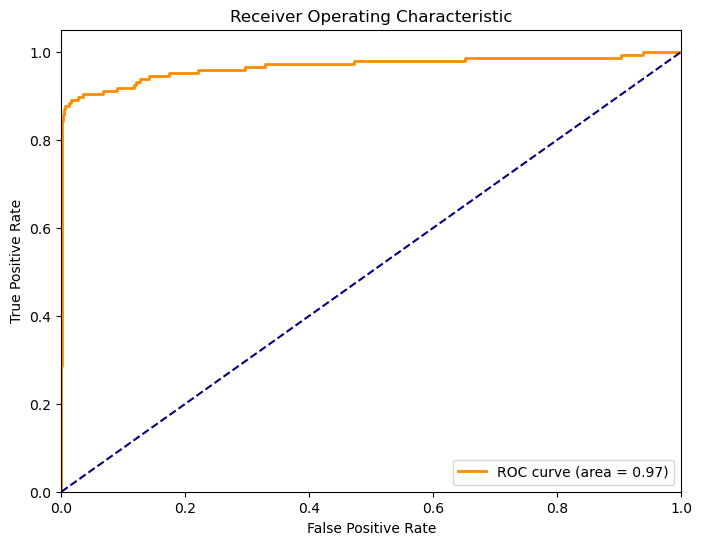

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100],
    'max_iter': [10, 20, 50, 70, 100],
}

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3 ,random_state=50)

grid_search2 = GridSearchCV(LinearSVC(random_state=50), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=3)
grid_search2.fit(x_train, y_train)

best_model2 = grid_search2.best_estimator_
y_pred = best_model2.predict(x_test)

print(classification_report(y_test, y_pred, target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test,  best_model2.decision_function(x_test))
auc = roc_auc_score(y_test, best_model2.decision_function(x_test))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Предсказание мошенничеств стало чуть чуть лучше но модель все еще переобучена на данных нормальных транзакций.
LinearSVC показывает небольшое улучшение в F1-score. Это гармоническое среднее precision и recall, и более высокое значение указывает на лучший баланс между точностью и полнотой.

              precision    recall  f1-score   support

     Обычная       1.00      1.00      1.00     85295
      Кардер       0.94      0.82      0.88       148

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



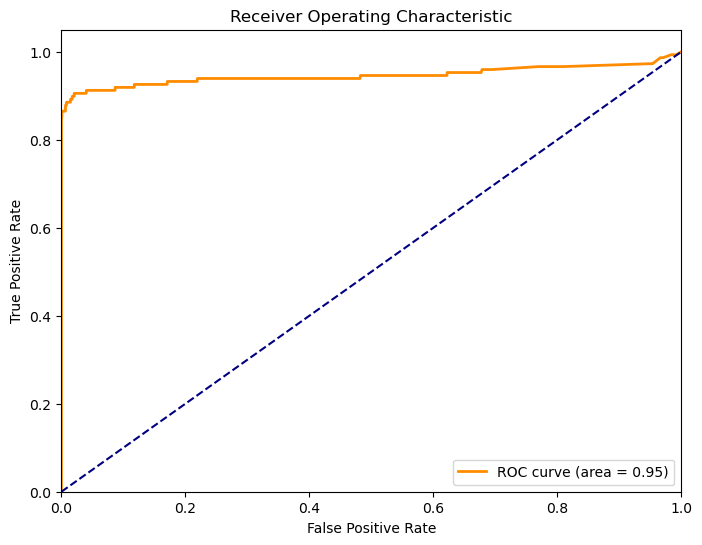

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators': [15, 25, 30], 
    'max_depth': [5, 10, 15, 20]
}

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50, stratify=y)

grid_search3 = GridSearchCV(RandomForestClassifier(random_state=50), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=3)
grid_search3.fit(x_train, y_train)

best_model3 = grid_search3.best_estimator_
y_pred = best_model3.predict(x_test)

print(classification_report(y_test, y_pred, target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test,  best_model3.predict_proba(x_test)[:,1])
auc = roc_auc_score(y_test, best_model3.predict_proba(x_test)[:,1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

удалось добиться хорошей точности и полноты с помощью рандомного леса. 

              precision    recall  f1-score   support

     Обычная       1.00      1.00      1.00     85295
      Кардер       0.93      0.75      0.83       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



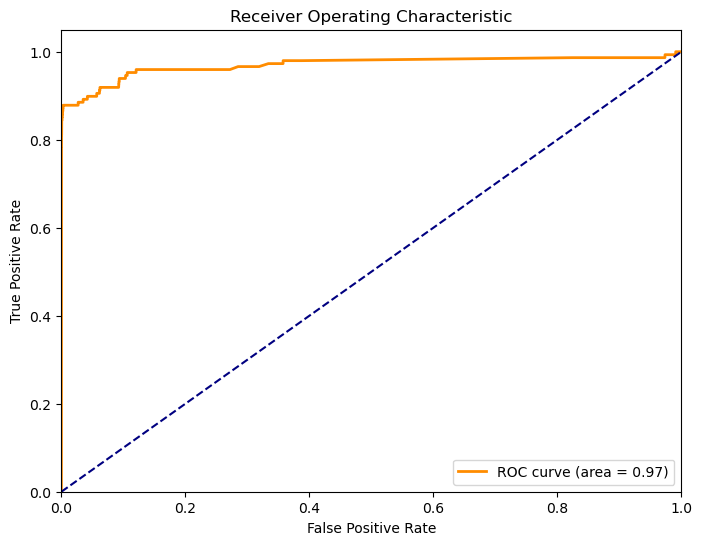

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

param_grid = {
    'learning_rate': [0.01, 0.1, 1], 
    'max_iter': [50, 100, 150],
    'max_depth': [3, 5, 10]
}

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3 ,random_state=50, stratify=y)

grid_search4 = GridSearchCV(HistGradientBoostingClassifier(random_state=50), param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=3)
grid_search4.fit(x_train, y_train)

best_model4 = grid_search4.best_estimator_
y_pred = best_model4.predict(x_test)

print(classification_report(y_test, y_pred,target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test,  best_model4.decision_function(x_test))
auc = roc_auc_score(y_test, best_model4.decision_function(x_test))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Следующий этап это обучение нейронки. Тут точно будет автоэнкодер и изолирующий лес. Данные буду разбивать с нуля потому что для автоэнкодера не надо увеличивать количество мошеннических транзакций. Отличие автоэнкодера от нейронки в том что я обучаю его только на нормальных транзакциях а мошенничества он будет считать выбросами.

готовим данные

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

creditcard_data = pd.read_csv("datasets/creditcard.csv")

robust_scaler = RobustScaler()
creditcard_data["Amount"] = robust_scaler.fit_transform(creditcard_data["Amount"].values.reshape(-1, 1)) 
creditcard_data["Time"] = robust_scaler.fit_transform(creditcard_data["Time"].values.reshape(-1, 1))

normal_data = creditcard_data[creditcard_data['Class'] == 0]
crime_data = creditcard_data[creditcard_data['Class'] == 1]

x_normal = normal_data.drop(columns='Class', axis=1).values

x_train, x_test = train_test_split(x_normal, test_size=0.2, random_state=50)

автоэнкодер

In [41]:
from tensorflow import keras

encoding_neuro = 5
input_neuro = x_train.shape[1]

input_layer = keras.Input(shape=(input_neuro,))

encoder = keras.layers.Dense(16, activation="tanh")(input_layer)
encoder = keras.layers.Dense(encoding_neuro, activation="relu")(encoder)

decoder = keras.layers.Dense(16, activation="tanh")(encoder)
decoder = keras.layers.Dense(input_neuro, activation="sigmoid")(decoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

print(autoencoder.summary())

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_12 (Dense)            (None, 16)                496       
                                                                 
 dense_13 (Dense)            (None, 5)                 85        
                                                                 
 dense_14 (Dense)            (None, 16)                96        
                                                                 
 dense_15 (Dense)            (None, 30)                510       
                                                                 
Total params: 1,187
Trainable params: 1,187
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
epochs = 20
batch_size = 100
history = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, x_test))

x_test_full = creditcard_data.drop(columns='Class', axis=1).values
y_test_full = creditcard_data['Class'].values

predictions_test = autoencoder.predict(x_test_full)
mse_test = np.mean(np.power(x_test_full - predictions_test, 2), axis=1)

Epoch 1/20
2275/2275 [==============================] - 5s 2ms/step - loss: 1.2498 - val_loss: 1.3621
Epoch 2/20
2275/2275 [==============================] - 4s 2ms/step - loss: 1.1784 - val_loss: 1.3381
Epoch 3/20
2275/2275 [==============================] - 4s 2ms/step - loss: 1.1636 - val_loss: 1.3285
Epoch 4/20
2275/2275 [==============================] - 5s 2ms/step - loss: 1.1563 - val_loss: 1.3233
Epoch 5/20
2275/2275 [==============================] - 13s 5ms/step - loss: 1.1519 - val_loss: 1.3194
Epoch 6/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.1462 - val_loss: 1.3116
Epoch 7/20
2275/2275 [==============================] - 14s 6ms/step - loss: 1.1398 - val_loss: 1.3065
Epoch 8/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.1357 - val_loss: 1.3031
Epoch 9/20
2275/2275 [==============================] - 14s 6ms/step - loss: 1.1325 - val_loss: 1.3003
Epoch 10/20
2275/2275 [==============================] - 13s 6ms/step - loss:

              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97    284315
       Fraud       0.03      0.86      0.05       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.51    284807
weighted avg       1.00      0.95      0.97    284807



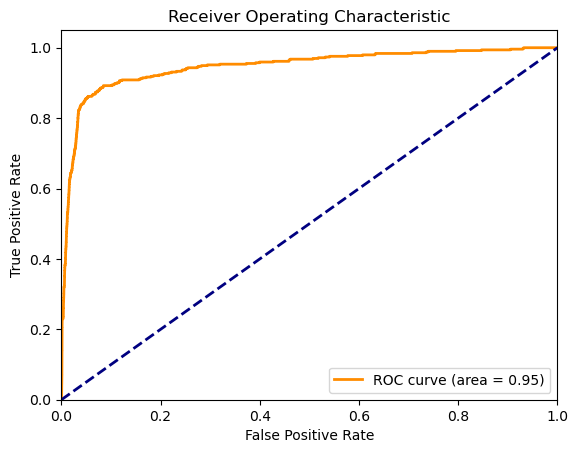

In [43]:
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test_full, mse_test)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

anomalies = (mse_test > optimal_threshold).astype(int)
print(classification_report(y_test_full, anomalies, target_names=['Normal', 'Fraud']))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
      

не очень хорошее предсказание потому что автоэнкодеры больше подходят для определения а не предсказания. Дальше на данных с автоэнкодера обучу случайный лес. (Но до этого посмотрим как себя покажет изолирующий лес)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

creditcard_data = pd.read_csv("datasets/creditcard.csv")

normal_data = creditcard_data[creditcard_data['Class'] == 0]
crime_data = creditcard_data[creditcard_data['Class'] == 1]

x_normal = normal_data.drop(columns='Class', axis=1).values

scaler = StandardScaler()
x_normal_scaled = scaler.fit_transform(x_normal)

x_train, x_test = train_test_split(x_normal_scaled, test_size=0.2, random_state=50)

[0.24216245 0.25915211 0.14647703 ... 0.22755199 0.16470149 0.23338305] [-0.24216245 -0.25915211 -0.14647703 ... -0.22755199 -0.16470149
 -0.23338305]
              precision    recall  f1-score   support

     Обычная       1.00      1.00      1.00    284315
      Кардер       0.21      0.35      0.26       492

    accuracy                           1.00    284807
   macro avg       0.60      0.67      0.63    284807
weighted avg       1.00      1.00      1.00    284807



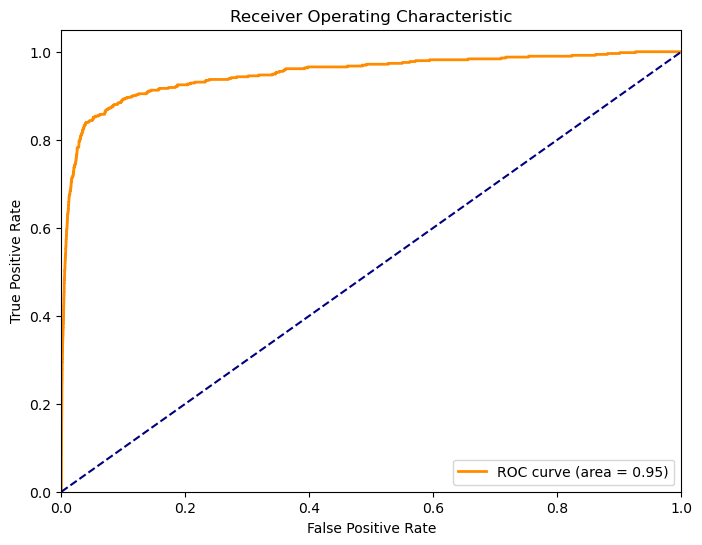

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

model5 = IsolationForest(n_estimators=100, contamination=float(len(crime_data)/len(normal_data)))
model5.fit(x_train)

x_test_full = creditcard_data.drop(columns='Class', axis=1).values
x_test_scaled_full = scaler.transform(x_test_full)
y_test_full = creditcard_data['Class'].values

y_pred = model5.predict(x_test_scaled_full)

scores = model5.decision_function(x_test_scaled_full)

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print(classification_report(y_test_full, y_pred, target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test_full,  -scores)
auc = roc_auc_score(y_test_full, -scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow import keras
from keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

creditcard_data = pd.read_csv("datasets/creditcard.csv")

robust_scaler = RobustScaler()
creditcard_data["Amount"] = robust_scaler.fit_transform(creditcard_data["Amount"].values.reshape(-1, 1))
creditcard_data["Time"] = robust_scaler.fit_transform(creditcard_data["Time"].values.reshape(-1, 1))

normal_data = creditcard_data[creditcard_data['Class'] == 0]
fraud_data = creditcard_data[creditcard_data['Class'] == 1]

X_normal = normal_data.drop(columns='Class', axis=1).values

X_train_normal, X_test_normal = train_test_split(X_normal, test_size=0.2, random_state=50)

input_dim = X_train_normal.shape[1]
encoding_dim = 10

input_layer = keras.Input(shape=(input_dim,))
encoder_layer = layers.Dense(encoding_dim, activation='relu')
encoder = encoder_layer(input_layer)

decoder_layer = layers.Dense(input_dim, activation='sigmoid') 
decoder = decoder_layer(encoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train_normal, X_train_normal, epochs=20, batch_size=100, shuffle=True, validation_data=(X_test_normal, X_test_normal))

Epoch 1/20
2275/2275 [==============================] - 4s 2ms/step - loss: 1.2054 - val_loss: 1.2984
Epoch 2/20
2275/2275 [==============================] - 3s 1ms/step - loss: 1.1177 - val_loss: 1.2792
Epoch 3/20
2275/2275 [==============================] - 4s 2ms/step - loss: 1.1071 - val_loss: 1.2732
Epoch 4/20
2275/2275 [==============================] - 3s 1ms/step - loss: 1.1022 - val_loss: 1.2695
Epoch 5/20
2275/2275 [==============================] - 3s 1ms/step - loss: 1.0992 - val_loss: 1.2669
Epoch 6/20
2275/2275 [==============================] - 3s 1ms/step - loss: 1.0963 - val_loss: 1.2645
Epoch 7/20
2275/2275 [==============================] - 4s 2ms/step - loss: 1.0950 - val_loss: 1.2635
Epoch 8/20
2275/2275 [==============================] - 4s 2ms/step - loss: 1.0941 - val_loss: 1.2628
Epoch 9/20
2275/2275 [==============================] - 9s 4ms/step - loss: 1.0934 - val_loss: 1.2622
Epoch 10/20
2275/2275 [==============================] - 12s 5ms/step - loss: 1.09

2671/2671 [==============================] - 2s 843us/step
              precision    recall  f1-score   support

     Обычная       1.00      1.00      1.00     85296
      Кардер       0.93      0.68      0.78       147

    accuracy                           1.00     85443
   macro avg       0.96      0.84      0.89     85443
weighted avg       1.00      1.00      1.00     85443



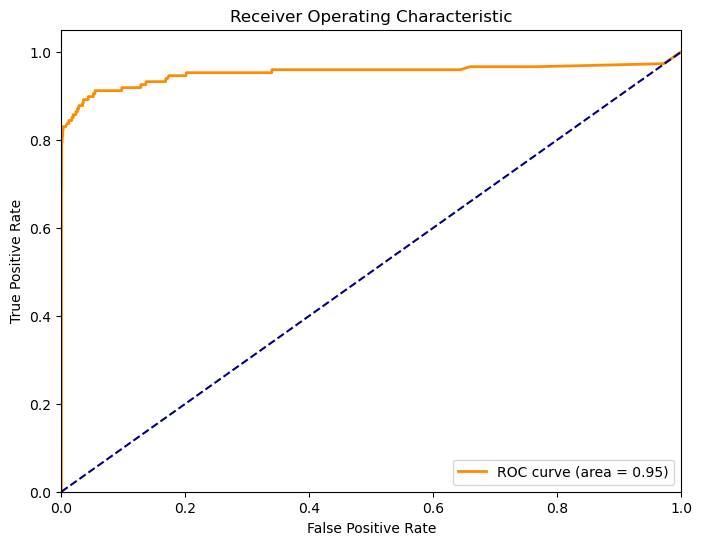

In [40]:
encoder_model = keras.Model(inputs=input_layer, outputs=encoder)

X = creditcard_data.drop(columns='Class', axis=1).values
y = creditcard_data['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)

classifier = RandomForestClassifier(n_estimators=30, max_depth=15,random_state=50)
classifier.fit(X_train_encoded, y_train)

y_pred = classifier.predict(X_test_encoded)
print(classification_report(y_test, y_pred, target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test, classifier.predict_proba(X_test_encoded)[:,1])
auc = roc_auc_score(y_test, classifier.predict_proba(X_test_encoded)[:,1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


ну вот тут видно что предсказание вышло хорошим но мы потеряли точность определения. Тоесть количество срабатываний больше чем реальных мошенничеств на 32%